# Определение перспективного тарифа для телеком компании

##### Задачи проекта:

###### 1. Посчитать для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя 

###### 2. Описать поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

###### 3. Проверить гипотезы
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

###  ОБЗОР ОБЩЕЙ ИНФОРМАЦИИ

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import numpy as np

In [2]:
calls=pd.read_csv('calls.csv')
internet=pd.read_csv('internet.csv')
messages=pd.read_csv('messages.csv')
tariffs=pd.read_csv('tariffs.csv')
users=pd.read_csv('users.csv')

In [3]:
users.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


In [4]:
users['reg_date'].min()

'2018-01-01'

In [5]:
users['reg_date'].max()

'2018-12-31'

Предоставлена информация с 1 января по 31 декабря 2018 года

In [6]:
users.isna().mean()

user_id       0.000
age           0.000
churn_date    0.924
city          0.000
first_name    0.000
last_name     0.000
reg_date      0.000
tariff        0.000
dtype: float64

Пропуски в дате прекращения пользования тарифом

In [7]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [8]:
messages.head(3)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


В таблице указана информация о датах сообщения. Для дальнейшего анализа необходимо будет добавить столбец о количество сообщений

In [9]:
calls.head(3)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


In [10]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Представлены данные о 3174 звонках; указана инфо о продолжительности звонков. Необходимо будет для дальнейших расчетов добавить столбец с количеством звонков

In [11]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


 Для анализа представлена инфо о 500 клиентах компании, пользующихся тарифами smart и ultra:возраст клиентов, город , инфо о тарифах, о продолжительности звонков, количестве сообщений, количестве используемых мегабайтах, даты регистрации и прекращения пользования тарифом. Данные представлены с 1 января по 31 декабря 2018г. Вся информация представлена в отдельных таблицах. Для анализа данных необходимо свести всю инфо в единую таблицу

### ОБЪЕДИНЕНИЕ ТАБЛИЦ

 Создадим столец в котором указывается первое число каждого месяца

In [12]:
users['date']=pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

In [13]:
users['month']=users['date'].values.astype('datetime64[M]')

In [14]:
users.reset_index().head(3)

,index,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,date,month
0,0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25,2018-05-01
1,1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,2018-11-01
2,2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17,2018-06-01


Информация о 500 клиентах. Используем данную таблицу для формирования основы таблицы к которой будем присоединять остальные таблицы (calls, messages, internet)

### Создадим основу для будущей таблицы

In [15]:
user=users.groupby('user_id')['month'].min().to_frame().reset_index()

In [16]:
user

,user_id,month
0,1000,2018-05-01
1,1001,2018-11-01
2,1002,2018-06-01
3,1003,2018-08-01
4,1004,2018-05-01
...,...,...
495,1495,2018-08-01
496,1496,2018-01-01
497,1497,2018-10-01
498,1498,2018-07-01


In [17]:
month=pd.DataFrame({'month':pd.date_range(users['month'].min(),user['month'].max(),freq='MS')})

In [18]:
user['key']=1

In [19]:
month['key']=1

Объединяем таблицы по ключу key

In [20]:
report=month.merge(user,on='key')

In [21]:
report

,month_x,key,user_id,month_y
0,2018-01-01,1,1000,2018-05-01
1,2018-01-01,1,1001,2018-11-01
2,2018-01-01,1,1002,2018-06-01
3,2018-01-01,1,1003,2018-08-01
4,2018-01-01,1,1004,2018-05-01
...,...,...,...,...
5995,2018-12-01,1,1495,2018-08-01
5996,2018-12-01,1,1496,2018-01-01
5997,2018-12-01,1,1497,2018-10-01
5998,2018-12-01,1,1498,2018-07-01


In [22]:
report[report['user_id']==1495]

,month_x,key,user_id,month_y
495,2018-01-01,1,1495,2018-08-01
995,2018-02-01,1,1495,2018-08-01
1495,2018-03-01,1,1495,2018-08-01
1995,2018-04-01,1,1495,2018-08-01
2495,2018-05-01,1,1495,2018-08-01
2995,2018-06-01,1,1495,2018-08-01
3495,2018-07-01,1,1495,2018-08-01
3995,2018-08-01,1,1495,2018-08-01
4495,2018-09-01,1,1495,2018-08-01
4995,2018-10-01,1,1495,2018-08-01


In [23]:
# удалим столбец key
report=month.merge(user,on='key').drop('key',axis=1)

In [24]:
report

,month_x,user_id,month_y
0,2018-01-01,1000,2018-05-01
1,2018-01-01,1001,2018-11-01
2,2018-01-01,1002,2018-06-01
3,2018-01-01,1003,2018-08-01
4,2018-01-01,1004,2018-05-01
...,...,...,...
5995,2018-12-01,1495,2018-08-01
5996,2018-12-01,1496,2018-01-01
5997,2018-12-01,1497,2018-10-01
5998,2018-12-01,1498,2018-07-01


In [25]:
# переименуем столбцы
report.columns=['reg_month', 'user_id', 'month']

Таблица report - это таблица к которой будем присоединять остальные табл. Добавим к ней инфо о клиентах

In [26]:
# добавим к таблице report инфо о клиентах
report=report.merge(users,how='left',on=['month','user_id'])

In [27]:
report.head(3)

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date
0,2018-01-01,1000,2018-05-01,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25
1,2018-01-01,1001,2018-11-01,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01
2,2018-01-01,1002,2018-06-01,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17


Посмотрим данную табл на пользователе №1495

In [28]:
report[report['user_id']==1495]

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date
495,2018-01-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
995,2018-02-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
1495,2018-03-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
1995,2018-04-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
2495,2018-05-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
2995,2018-06-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
3495,2018-07-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
3995,2018-08-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
4495,2018-09-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28
4995,2018-10-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28


##### Изучим данные о звонках

In [29]:
calls

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [30]:
calls.isna().mean()

id           0.0
call_date    0.0
duration     0.0
user_id      0.0
dtype: float64

In [31]:
calls['date']=pd.to_datetime(calls['call_date'],format='%Y-%m-%d')

In [32]:
calls['reg_month']=calls['date'].values.astype('datetime64[M]')

 «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Округлим значения длительности звонков

In [33]:
calls

,id,call_date,duration,user_id,date,reg_month
0,1000_0,2018-07-25,0.00,1000,2018-07-25,2018-07-01
1,1000_1,2018-08-17,0.00,1000,2018-08-17,2018-08-01
2,1000_2,2018-06-11,2.85,1000,2018-06-11,2018-06-01
3,1000_3,2018-09-21,13.80,1000,2018-09-21,2018-09-01
4,1000_4,2018-12-15,5.18,1000,2018-12-15,2018-12-01
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,2018-12-26,2018-12-01
202603,1499_216,2018-10-18,18.83,1499,2018-10-18,2018-10-01
202604,1499_217,2018-11-10,10.81,1499,2018-11-10,2018-11-01
202605,1499_218,2018-10-06,4.27,1499,2018-10-06,2018-10-01


In [34]:
calls.loc[calls['duration']!=0,'duration']+=1

Создадим столбец в котором будут отбражаться количество звонков

In [35]:
calls['call_count']=(calls['duration']>0)*1

In [36]:
calls=pd.pivot_table(calls,index=['user_id','reg_month'],values=['duration','call_count'],aggfunc='sum')

In [37]:
calls

call_count  duration
user_id reg_month                       
1000    2018-05-01          17    167.06
        2018-06-01          28    186.90
        2018-07-01          41    359.80
        2018-08-01          42    431.87
        2018-09-01          46    486.14
...                        ...       ...
1498    2018-10-01          30    262.63
1499    2018-09-01           8     72.65
        2018-10-01          44    473.91
        2018-11-01          62    638.50
        2018-12-01          56    521.16

[3174 rows x 2 columns]

In [38]:
calls[calls['duration']==0].count()

call_count    6
duration      6
dtype: int64

In [39]:
calls['duration'].round()

user_id  reg_month 
1000     2018-05-01    167.0
         2018-06-01    187.0
         2018-07-01    360.0
         2018-08-01    432.0
         2018-09-01    486.0
                       ...  
1498     2018-10-01    263.0
1499     2018-09-01     73.0
         2018-10-01    474.0
         2018-11-01    638.0
         2018-12-01    521.0
Name: duration, Length: 3174, dtype: float64

In [40]:
# Добавляем таблицу calls к таблице report
report=report.merge(calls,how='left',on=['reg_month','user_id'])

In [41]:
report

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration
0,2018-01-01,1000,2018-05-01,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25,NaN,NaN
1,2018-01-01,1001,2018-11-01,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,NaN,NaN
2,2018-01-01,1002,2018-06-01,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17,NaN,NaN
3,2018-01-01,1003,2018-08-01,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-17,NaN,NaN
4,2018-01-01,1004,2018-05-01,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-14,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,120.0,1090.94
5996,2018-12-01,1496,2018-01-01,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,2018-01-27,65.0,548.91
5997,2018-12-01,1497,2018-10-01,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,2018-10-09,58.0,573.33
5998,2018-12-01,1498,2018-07-01,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-07-19,NaN,NaN


In [42]:
report[report['user_id']==1495]

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration
495,2018-01-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
995,2018-02-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
1495,2018-03-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
1995,2018-04-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
2495,2018-05-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
2995,2018-06-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
3495,2018-07-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,NaN,NaN
3995,2018-08-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,13.0,100.03
4495,2018-09-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,95.0,861.62
4995,2018-10-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,126.0,1097.33


Изучим сообщения пользователей

In [43]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [44]:
# Создадим столбец в котором будут отображаться количество сообщений
messages['messages']=1

In [45]:
# приведем дату к формату
messages['date']=pd.to_datetime(messages['message_date'],format='%Y-%m-%d')

In [46]:
messages['reg_month']=messages['date'].values.astype('datetime64[M]')

In [47]:
messages

,id,message_date,user_id,messages,date,reg_month
0,1000_0,2018-06-27,1000,1,2018-06-27,2018-06-01
1,1000_1,2018-10-08,1000,1,2018-10-08,2018-10-01
2,1000_2,2018-08-04,1000,1,2018-08-04,2018-08-01
3,1000_3,2018-06-16,1000,1,2018-06-16,2018-06-01
4,1000_4,2018-12-05,1000,1,2018-12-05,2018-12-01
...,...,...,...,...,...,...
123031,1499_179,2018-12-12,1499,1,2018-12-12,2018-12-01
123032,1499_180,2018-09-28,1499,1,2018-09-28,2018-09-01
123033,1499_181,2018-09-27,1499,1,2018-09-27,2018-09-01
123034,1499_182,2018-11-15,1499,1,2018-11-15,2018-11-01


In [48]:
# создаем сводную таблицу по всем сообщенияб для каждого пользователя
messages=pd.pivot_table(messages,index=['user_id','reg_month'],values='messages',aggfunc='sum')

In [49]:
messages

messages
user_id reg_month           
1000    2018-05-01        22
        2018-06-01        60
        2018-07-01        75
        2018-08-01        81
        2018-09-01        57
...                      ...
1498    2018-10-01        42
1499    2018-09-01        11
        2018-10-01        48
        2018-11-01        59
        2018-12-01        66

[2717 rows x 1 columns]

In [50]:
# Добавим таблицу messages к таблице report
report=report.merge(messages,how='left',on=['reg_month','user_id'])


In [51]:
report

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration,messages
0,2018-01-01,1000,2018-05-01,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25,NaN,NaN,NaN
1,2018-01-01,1001,2018-11-01,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,NaN,NaN,NaN
2,2018-01-01,1002,2018-06-01,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17,NaN,NaN,NaN
3,2018-01-01,1003,2018-08-01,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-17,NaN,NaN,NaN
4,2018-01-01,1004,2018-05-01,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-14,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,120.0,1090.94,84.0
5996,2018-12-01,1496,2018-01-01,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,2018-01-27,65.0,548.91,51.0
5997,2018-12-01,1497,2018-10-01,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,2018-10-09,58.0,573.33,17.0
5998,2018-12-01,1498,2018-07-01,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-07-19,NaN,NaN,NaN


Изучим данные об интернете

In [52]:
internet

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


In [53]:
# округляем
internet['mb_used'].round()

0          113.0
1         1053.0
2         1197.0
3          550.0
4          303.0
           ...  
149391     319.0
149392     490.0
149393       0.0
149394    1246.0
149395     544.0
Name: mb_used, Length: 149396, dtype: float64

In [54]:
# форматируем дату
internet['date']=pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

In [55]:
internet['reg_month']=internet['date'].values.astype('datetime64[M]')

In [56]:
# сводная таблица по используемым мегабайтам для каждого пользователя
internet=pd.pivot_table(internet,index=['user_id','reg_month'],values='mb_used',aggfunc='sum')

In [57]:
# Добавим таблицу internet к таблице report
report=report.merge(internet,how='left',on=['reg_month','user_id'])

In [58]:
report

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration,messages,mb_used
0,2018-01-01,1000,2018-05-01,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05-25,NaN,NaN,NaN,NaN
1,2018-01-01,1001,2018-11-01,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,2018-11-01,NaN,NaN,NaN,NaN
2,2018-01-01,1002,2018-06-01,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,2018-06-17,NaN,NaN,NaN,NaN
3,2018-01-01,1003,2018-08-01,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,2018-08-17,NaN,NaN,NaN,NaN
4,2018-01-01,1004,2018-05-01,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,2018-05-14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2018-12-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,120.0,1090.94,84.0,23426.76
5996,2018-12-01,1496,2018-01-01,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart,2018-01-27,65.0,548.91,51.0,20736.15
5997,2018-12-01,1497,2018-10-01,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart,2018-10-09,58.0,573.33,17.0,19918.60
5998,2018-12-01,1498,2018-07-01,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,2018-07-19,NaN,NaN,NaN,NaN


Создали большую таблицу со всей информацией. Из таблицы видно о наличии пропусков. Приступим к преобработке данных

## 2. ПРЕОБРАБОТКА ДАННЫХ

In [59]:
report.isna().mean()

reg_month     0.000000
user_id       0.000000
month         0.000000
age           0.000000
churn_date    0.924000
city          0.000000
first_name    0.000000
last_name     0.000000
reg_date      0.000000
tariff        0.000000
date          0.000000
call_count    0.471000
duration      0.471000
messages      0.547167
mb_used       0.466167
dtype: float64

In [60]:
# Удалим строки в которых пропущена инфо о продолжительности звонков.
report.dropna(subset=['duration'],inplace=True)

In [61]:
report.head(5)

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration,messages,mb_used
5,2018-01-01,1005,2018-01-01,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,2018-01-25,11.0,101.93,7.0,2727.97
32,2018-01-01,1032,2018-01-01,31,NaN,Ульяновск,Инна,Игнатьева,2018-01-04,smart,2018-01-04,44.0,403.16,38.0,24127.69
45,2018-01-01,1045,2018-01-01,48,NaN,Улан-Удэ,Джемма,Карасева,2018-01-30,smart,2018-01-30,1.0,9.33,5.0,2346.71
55,2018-01-01,1055,2018-01-01,39,NaN,Казань,Луиза,Березина,2018-01-02,smart,2018-01-02,47.0,574.95,30.0,17090.88
71,2018-01-01,1071,2018-01-01,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,2018-01-09,18.0,201.96,16.0,15604.34


In [62]:
report.dtypes

reg_month     datetime64[ns]
user_id                int64
month         datetime64[ns]
age                    int64
churn_date            object
city                  object
first_name            object
last_name             object
reg_date              object
tariff                object
date          datetime64[ns]
call_count           float64
duration             float64
messages             float64
mb_used              float64
dtype: object

In [63]:
report[report['user_id']==1495]

,reg_month,user_id,month,age,churn_date,city,first_name,last_name,reg_date,tariff,date,call_count,duration,messages,mb_used
3995,2018-08-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,13.0,100.03,13.0,2614.07
4495,2018-09-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,95.0,861.62,82.0,33067.62
4995,2018-10-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,126.0,1097.33,82.0,29363.00
5495,2018-11-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,112.0,1004.65,79.0,38939.11
5995,2018-12-01,1495,2018-08-01,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra,2018-08-28,120.0,1090.94,84.0,23426.76


Если о звонках, сообщениях, интернете нет инфо - значит пользователь не был пользовался данными услугами (заменим пропуски 0)
Инфо о пропущенной дате прекращения тарифа заменим датой 2019-01-01 (не указанна информация - значит тариф активен)

In [64]:
report['churn_date']=report['churn_date'].fillna('2019-01-01')

In [65]:
report['churn_date']=pd.to_datetime(report['churn_date'],format='%Y-%m-%d')

In [66]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


 Создадим сводну таблицу для каждого пользователя:
 
количество сделанных звонков и израсходованных минут разговора по месяцам;

количество отправленных сообщений по месяцам;

объем израсходованного интернет-трафика по месяцам;

In [67]:
users_report=pd.pivot_table(report,index=['user_id','reg_month','tariff'],\
                            values=['duration','call_count','messages','mb_used'],aggfunc='sum').reset_index()

In [68]:
users_report.head(5)

,user_id,reg_month,tariff,call_count,duration,mb_used,messages
0,1000,2018-05-01,ultra,17.0,167.06,2253.49,22.0
1,1000,2018-06-01,ultra,28.0,186.90,23233.77,60.0
2,1000,2018-07-01,ultra,41.0,359.80,14003.64,75.0
3,1000,2018-08-01,ultra,42.0,431.87,14055.93,81.0
4,1000,2018-09-01,ultra,46.0,486.14,14568.91,57.0


Расчитаем для каждого пользователя размер ежемесячной абон. платы включая платы за минуты сверх тарифа

In [69]:

def pay (row):
    pay=0
    if row['tariff']=='ultra':
        if row['duration']>3000:
            pay=(row['duration']-3000)*1+1950
        elif row['duration']>0:
            pay+=1950
    
    if row['tariff']=='smart':
        if row['duration']>500:
            pay=(row['duration']-500)*3+550
        elif row['duration']>0:
            pay+=550
    
    return pay

users_report['revenue_min']=users_report.apply(pay,axis=1)                                                               

In [70]:
users_report[users_report['user_id']==1400]

,user_id,reg_month,tariff,call_count,duration,mb_used,messages,revenue_min
2530,1400,2018-08-01,smart,20.0,207.44,7414.15,9.0,550.00
2531,1400,2018-09-01,smart,53.0,478.07,19451.55,51.0,550.00
2532,1400,2018-10-01,smart,70.0,645.81,25824.99,58.0,987.43
2533,1400,2018-11-01,smart,65.0,543.78,26115.12,63.0,681.34
2534,1400,2018-12-01,smart,63.0,640.07,21729.02,59.0,970.21


Расчитаем плату за сообщения сверх тарифа

In [71]:
def mes (row):
    mes=0
    if row['tariff']=='ultra':
        if row['messages']>50:
            mes=(row['messages']-50)*1
            
    if row['tariff']=='smart':
        if row['messages']>1000:
            mes=(row['messages']-1000)*3
    
    return mes

users_report['revenue_mes']=users_report.apply(mes,axis=1)    

In [72]:
users_report[users_report['user_id']==1400]

,user_id,reg_month,tariff,call_count,duration,mb_used,messages,revenue_min,revenue_mes
2530,1400,2018-08-01,smart,20.0,207.44,7414.15,9.0,550.00,0.0
2531,1400,2018-09-01,smart,53.0,478.07,19451.55,51.0,550.00,0.0
2532,1400,2018-10-01,smart,70.0,645.81,25824.99,58.0,987.43,0.0
2533,1400,2018-11-01,smart,65.0,543.78,26115.12,63.0,681.34,0.0
2534,1400,2018-12-01,smart,63.0,640.07,21729.02,59.0,970.21,0.0


In [73]:
users_report['revenue_mes'].sum()

17904.0

Расчитаем плату за сверх мегабайты

In [74]:
def web (row):
    web=0
    if row['tariff']=='ultra':
        if row['mb_used']>30720:
            web=(row['mb_used']-30720)*0.146
            
    if row['tariff']=='smart':
        if row['mb_used']>1024:
            web=(row['mb_used']-15360)*0.195
    
    return web

users_report['revenue_web']=users_report.apply(web,axis=1)  

In [75]:
# заполним 0 отрицательные значения - те кто не израсходовал предоставленный лимит
users_report.loc[users_report['revenue_web']<0, 'revenue_web'] = 0

In [76]:
users_report[users_report['user_id']==1400]

,user_id,reg_month,tariff,call_count,duration,mb_used,messages,revenue_min,revenue_mes,revenue_web
2530,1400,2018-08-01,smart,20.0,207.44,7414.15,9.0,550.00,0.0,0.00000
2531,1400,2018-09-01,smart,53.0,478.07,19451.55,51.0,550.00,0.0,797.85225
2532,1400,2018-10-01,smart,70.0,645.81,25824.99,58.0,987.43,0.0,2040.67305
2533,1400,2018-11-01,smart,65.0,543.78,26115.12,63.0,681.34,0.0,2097.24840
2534,1400,2018-12-01,smart,63.0,640.07,21729.02,59.0,970.21,0.0,1241.95890


In [77]:
users_report['revenue_web'].sum()

1300847.38489

###### Расчитаем помесячную выручки с каждого клиента

In [78]:
users_report['revenue']=users_report['revenue_web']+users_report['revenue_mes']+users_report['revenue_min']

In [79]:
users_report[users_report['user_id']==1400]

,user_id,reg_month,tariff,call_count,duration,mb_used,messages,revenue_min,revenue_mes,revenue_web,revenue
2530,1400,2018-08-01,smart,20.0,207.44,7414.15,9.0,550.00,0.0,0.00000,550.00000
2531,1400,2018-09-01,smart,53.0,478.07,19451.55,51.0,550.00,0.0,797.85225,1347.85225
2532,1400,2018-10-01,smart,70.0,645.81,25824.99,58.0,987.43,0.0,2040.67305,3028.10305
2533,1400,2018-11-01,smart,65.0,543.78,26115.12,63.0,681.34,0.0,2097.24840,2778.58840
2534,1400,2018-12-01,smart,63.0,640.07,21729.02,59.0,970.21,0.0,1241.95890,2212.16890


In [80]:
users_report['revenue'].sum()

4748257.64489

In [81]:
users_report['revenue'].mean()

1495.9853953654695

##### Годовая выручка Мегалайна от 500 клиентов - 4748258 руб 

In [82]:
users_report['revenue']=users_report['revenue'].astype(int)

In [83]:
users_report

,user_id,reg_month,tariff,call_count,duration,mb_used,messages,revenue_min,revenue_mes,revenue_web,revenue
0,1000,2018-05-01,ultra,17.0,167.06,2253.49,22.0,1950.00,0.0,0.00000,1950
1,1000,2018-06-01,ultra,28.0,186.90,23233.77,60.0,1950.00,10.0,0.00000,1960
2,1000,2018-07-01,ultra,41.0,359.80,14003.64,75.0,1950.00,25.0,0.00000,1975
3,1000,2018-08-01,ultra,42.0,431.87,14055.93,81.0,1950.00,31.0,0.00000,1981
4,1000,2018-09-01,ultra,46.0,486.14,14568.91,57.0,1950.00,7.0,0.00000,1957
...,...,...,...,...,...,...,...,...,...,...,...
3169,1498,2018-10-01,smart,30.0,262.63,20579.36,42.0,550.00,0.0,1017.77520,1567
3170,1499,2018-09-01,smart,8.0,72.65,1845.75,11.0,550.00,0.0,0.00000,550
3171,1499,2018-10-01,smart,44.0,473.91,17788.51,48.0,550.00,0.0,473.55945,1023
3172,1499,2018-11-01,smart,62.0,638.50,17963.31,59.0,965.50,0.0,507.64545,1473


In [84]:
users_report.dtypes

user_id                 int64
reg_month      datetime64[ns]
tariff                 object
call_count            float64
duration              float64
mb_used               float64
messages              float64
revenue_min           float64
revenue_mes           float64
revenue_web           float64
revenue                 int32
dtype: object

После создания большой сводной таблицы для каждого клиента по месяцам было расчитано: количество и продолжительность звонков, количество сообщений, количество израсходованных мегабайтов, а также расчитана ежемесячная плата каждого клиента. Теперь перейдем к изучению тарифов

## 3. АНАЛИЗ ДАННЫХ

### Сравним 2 тарифа: "Смарт" и "Ультра"

In [85]:
tarif=\
    pd.pivot_table(users_report,
                   index=['tariff','reg_month'],
                   values=['duration','call_count','messages','mb_used','revenue'],
                   aggfunc='sum').reset_index()

In [86]:
tarif_ultra=\
    pd.pivot_table(users_report[users_report['tariff']=='ultra'],
                   index=['tariff','reg_month'],
                   values=['duration','call_count','messages','mb_used','revenue'],
                   aggfunc=['sum','mean']).reset_index()

In [87]:
tarif_smart=\
    pd.pivot_table(users_report[users_report['tariff']=='smart'],
                   index=['tariff','reg_month'],
                   values=['duration','call_count','messages','mb_used','revenue'],
                   aggfunc=['sum','mean']).reset_index()

In [88]:
tarif_smart = \
    pd.pivot_table(users_report[users_report['tariff']=='smart'],
                   index=['tariff','reg_month'],
                   values=['duration','call_count','messages','mb_used','revenue'],
                   aggfunc=['sum','mean']).reset_index()

# Тариф ультра

In [89]:
tarif_ultra

tariff  reg_month        sum                                         \
                     call_count  duration     mb_used messages revenue   
0   ultra 2018-01-01      420.0   4063.00   118266.13    304.0   17604   
1   ultra 2018-02-01      816.0   7549.70   282622.50    527.0   45455   
2   ultra 2018-03-01     2007.0  19114.31   648815.36   1195.0   74524   
3   ultra 2018-04-01     2862.0  26615.99   922093.12   1727.0  106331   
4   ultra 2018-05-01     3884.0  36159.49  1259195.98   2423.0  132566   
5   ultra 2018-06-01     4537.0  42583.21  1531616.05   3244.0  165832   
6   ultra 2018-07-01     5576.0  52464.02  1799337.86   4266.0  185538   
7   ultra 2018-08-01     6152.0  57719.06  2017964.20   4930.0  213352   
8   ultra 2018-09-01     6946.0  65494.16  2119481.41   5751.0  223554   
9   ultra 2018-10-01     7703.0  72502.98  2368771.88   6899.0  246055   
10  ultra 2018-11-01     8133.0  76593.94  2533648.34   7224.0  271209   
11  ultra 2018-12-01     9312.0  87100.34  2906983.04   8141.0  287506   

         mean                                                    
   call_count    duration       mb_used   messages      revenue  
0   46.666667  451.444444  13140.681111  33.777778  1956.000000  
1   34.000000  314.570833  11775.937500  21.958333  1893.958333  
2   54.243243  516.602973  17535.550270  32.297297  2014.162162  
3   54.000000  502.188491  17397.983396  32.584906  2006.245283  
4   60.687500  564.992031  19674.937188  37.859375  2071.343750  
5   56.012346  525.718642  18908.840123  40.049383  2047.308642  
6   63.363636  596.182045  20447.021136  48.477273  2108.386364  
7   59.728155  560.379223  19591.885437  47.864078  2071.378641  
8   62.576577  590.037477  19094.427117  51.810811  2014.000000  
9   65.279661  614.432034  20074.337966  58.466102  2085.211864  
10  63.046512  593.751473  19640.684806  56.000000  2102.395349  
11  69.492537  650.002537  21693.903284  60.753731  2145.567164

## Тариф смарт

In [90]:
tarif_smart

tariff  reg_month        sum                                          \
                     call_count   duration     mb_used messages revenue   
0   smart 2018-01-01      744.0    7307.44   289466.40    620.0   23353   
1   smart 2018-02-01     1889.0   18300.88   672629.15   1397.0   47388   
2   smart 2018-03-01     3376.0   31702.54  1163020.25   2453.0   87088   
3   smart 2018-04-01     4642.0   43418.93  1507764.23   3443.0  104211   
4   smart 2018-05-01     6232.0   57727.28  2228530.99   4762.0  163521   
5   smart 2018-06-01     7296.0   68499.50  2577879.39   5430.0  189624   
6   smart 2018-07-01     9204.0   86689.21  3164373.22   6784.0  237832   
7   smart 2018-08-01    11105.0  104609.57  3892468.66   7888.0  298554   
8   smart 2018-09-01    12500.0  117675.00  4221724.19   8714.0  315676   
9   smart 2018-10-01    14054.0  132322.40  4907034.69   9906.0  386845   
10  smart 2018-11-01    15531.0  145276.29  5321548.58  10748.0  409646   
11  smart 2018-12-01    18073.0  170294.80  6086981.60  12095.0  514108   

         mean                                                    
   call_count    duration       mb_used   messages      revenue  
0   21.882353  214.924706   8513.717647  18.235294   686.852941  
1   32.568966  315.532414  11597.054310  24.086207   817.034483  
2   43.844156  411.721299  15104.159091  31.857143  1131.012987  
3   41.446429  387.669018  13462.180625  30.741071   930.455357  
4   44.198582  409.413333  15805.184326  33.773050  1159.723404  
5   44.760736  420.242331  15815.210982  33.312883  1163.337423  
6   45.791045  431.289602  15743.150348  33.751244  1183.243781  
7   47.457265  447.049444  16634.481453  33.709402  1275.871795  
8   48.262548  454.343629  16300.093398  33.644788  1218.826255  
9   47.965870  451.612287  16747.558669  33.808874  1320.290102  
10  49.304762  461.194571  16893.805016  34.120635  1300.463492  
11  53.788690  506.829762  18116.016667  35.997024  1530.083333

In [91]:
tarif_ultra_2=pd.pivot_table(users_report[users_report['tariff']=='ultra'],\
            index=['tariff'],values=['duration','call_count','messages','mb_used','revenue'],\
                                  aggfunc=['sum','mean']).reset_index()
tarif_smart_2=pd.pivot_table(users_report[users_report['tariff']=='smart'],\
                             index=['tariff'],values=['duration','call_count','messages','mb_used','revenue'],\
                                 aggfunc=['sum','mean']).reset_index()

In [92]:
tarif_ultra_2

tariff        sum                                                mean  \
         call_count  duration      mb_used messages  revenue call_count   
0  ultra    58348.0  547960.2  18508795.87  46631.0  1969526  61.354364   

                                                     
     duration       mb_used   messages      revenue  
0  576.193691  19462.456225  49.033649  2071.005258

In [93]:
tarif_smart_2

tariff        sum                                                 mean  \
         call_count   duration      mb_used messages  revenue call_count   
0  smart   104646.0  983823.84  36033421.35  74240.0  2777846  47.074224   

                                                    
    duration       mb_used   messages      revenue  
0  442.56583  16209.366329  33.396311  1249.593342

##### Как видно из таблиц более активные пользователи тарифа ultra (средние продолжительность и количество звонков выше).Также у пользователей тарифа ultra более высокая средняя выручка

### Сравним 2 тарифа

###### График динамики медианной продолжительности звонков двух тарифов

Text(0.5, 1.0, 'Динамика медианной продолжительности звонков двух тарифов')

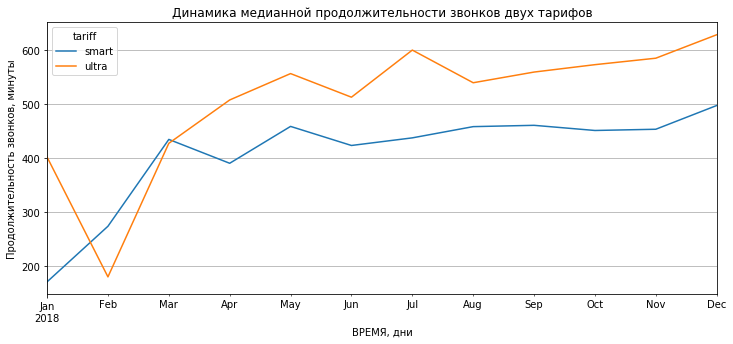

In [94]:
(users_report
    .pivot_table(index='reg_month', columns = 'tariff', values='duration', aggfunc='median')
    .plot(grid=True, figsize=(12, 5))
)
plt.xlabel('ВРЕМЯ, дни') 
plt.ylabel('Продолжительность звонков, минуты') 
plt.title('Динамика медианной продолжительности звонков двух тарифов')



###### График динамики средней продолжительности звонков двух тарифов

Text(0.5, 1.0, 'Динамика средняя продолжительности звонков двух тарифов')

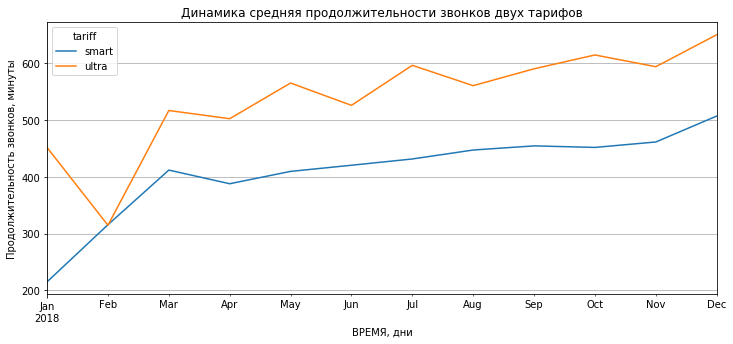

In [95]:
(users_report
    .pivot_table(index='reg_month', columns = 'tariff', values='duration', aggfunc='mean')
    .plot(grid=True, figsize=(12, 5))
)
plt.xlabel('ВРЕМЯ, дни') 
plt.ylabel('Продолжительность звонков, минуты') 
plt.title('Динамика средняя продолжительности звонков двух тарифов')

###### У двух тарифов схожая тенденция к увеличению длительности звонков с января по декабрь. Пользователи тарифа "ультра" больше общаются

###### График динамики средней выручки двух тарифов

Text(0.5, 1.0, 'Динамика средней выручки двух тарифов')

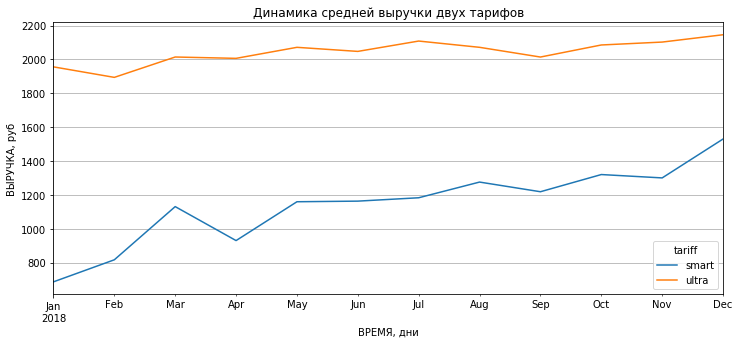

In [96]:
(users_report
    .pivot_table(index='reg_month', columns = 'tariff', values='revenue', aggfunc='mean')
    .plot(grid=True, figsize=(12, 5))
)
plt.xlabel('ВРЕМЯ, дни') 
plt.ylabel('ВЫРУЧКА, руб') 
plt.title('Динамика средней выручки двух тарифов')

###### Если сравнивать выручку 2-х тарифов: видна небольшая динамика в сторону увеличения средней выручки двух тарифов, причем у тарифа smart динамика выше (прирост) чем у пользователей тарифа smart. Если смотреть в целом: средняя выручка у пользователей тарифа ultra выше

##### Расчитаем средние показатели

In [97]:
smart=users_report[users_report['tariff']=='smart'].groupby('reg_month')\
           ['call_count','duration','mb_used','messages','revenue'].mean()

C:\Users\MaNi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Средние показатели тарифа СМАРТ

In [98]:
smart

,call_count,duration,mb_used,messages,revenue
reg_month,,,,,
2018-01-01,21.882353,214.924706,8513.717647,18.235294,686.852941
2018-02-01,32.568966,315.532414,11597.054310,24.086207,817.034483
2018-03-01,43.844156,411.721299,15104.159091,31.857143,1131.012987
2018-04-01,41.446429,387.669018,13462.180625,30.741071,930.455357
2018-05-01,44.198582,409.413333,15805.184326,33.773050,1159.723404
2018-06-01,44.760736,420.242331,15815.210982,33.312883,1163.337423
2018-07-01,45.791045,431.289602,15743.150348,33.751244,1183.243781
2018-08-01,47.457265,447.049444,16634.481453,33.709402,1275.871795
2018-09-01,48.262548,454.343629,16300.093398,33.644788,1218.826255


In [99]:
ultra=users_report[users_report['tariff']=='ultra'].groupby('reg_month')\
                        ['call_count','duration','mb_used','messages','revenue'].mean()


C:\Users\MaNi\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


##### Средние показатели тарифа УЛЬТРА

In [100]:
ultra

,call_count,duration,mb_used,messages,revenue
reg_month,,,,,
2018-01-01,46.666667,451.444444,13140.681111,33.777778,1956.000000
2018-02-01,34.000000,314.570833,11775.937500,21.958333,1893.958333
2018-03-01,54.243243,516.602973,17535.550270,32.297297,2014.162162
2018-04-01,54.000000,502.188491,17397.983396,32.584906,2006.245283
2018-05-01,60.687500,564.992031,19674.937188,37.859375,2071.343750
2018-06-01,56.012346,525.718642,18908.840123,40.049383,2047.308642
2018-07-01,63.363636,596.182045,20447.021136,48.477273,2108.386364
2018-08-01,59.728155,560.379223,19591.885437,47.864078,2071.378641
2018-09-01,62.576577,590.037477,19094.427117,51.810811,2014.000000


##### Расчитаем дисперсию и стандартное отклонение для тарифов

In [101]:
ultra=pd.pivot_table(users_report[users_report['tariff']=='ultra'],index=['user_id'],\
                     values=['duration','call_count','messages','mb_used','revenue'],aggfunc='sum').reset_index()

In [102]:
smart=pd.pivot_table(users_report[users_report['tariff']=='smart'],index=['user_id'],\
                     values=['duration','call_count','messages','mb_used','revenue'],aggfunc='sum').reset_index()

In [103]:
smart_var_duration=np.var(smart['duration'],ddof=1)
smart_var_messages=np.var(smart['messages'],ddof=1)
smart_var_mb_used=np.var(smart['mb_used'],ddof=1)
smart_var_revenue=np.var(smart['revenue'],ddof=1)
smart_std_duration=np.std(smart['duration'],ddof=1)
smart_std_messages=np.std(smart['messages'],ddof=1)
smart_std_mb_used=np.std(smart['mb_used'],ddof=1)
smart_std_revenue=np.std(smart['revenue'],ddof=1)
smart_mean_duration=smart['duration'].mean()
smart_mean_messages=smart['messages'].mean()
smart_mean_mb_used=smart['mb_used'].mean()
smart_mean_revenue=smart['revenue'].mean()


In [104]:
ultra_var_duration=np.var(ultra['duration'],ddof=1)
ultra_var_messages=np.var(ultra['messages'],ddof=1)
ultra_var_mb_used=np.var(ultra['mb_used'],ddof=1)
ultra_var_revenue=np.var(ultra['revenue'],ddof=1)
ultra_std_duration=np.std(ultra['duration'],ddof=1)
ultra_std_messages=np.std(ultra['messages'],ddof=1)
ultra_std_mb_used=np.std(ultra['mb_used'],ddof=1)
ultra_std_revenue=np.std(ultra['revenue'],ddof=1)
ultra_mean_duration=ultra['duration'].mean()
ultra_mean_messages=ultra['messages'].mean()
ultra_mean_mb_used=ultra['mb_used'].mean()
ultra_mean_revenue=ultra['revenue'].mean()


In [105]:
print('Тариф СМАРТ')
print(' ')
print('Продолжительность звонка:')
print('Среднемесячная: {:.2f}'.format(smart_mean_duration))
print('Дисперсия: {:.2f}'.format(smart_var_duration))
print('Стандартное отклонение: {:.2f}'.format(smart_std_duration))
print(' ')
print('Сообщения:')
print('Среднемесячная: {:.2f}'.format(smart_mean_messages))
print('Дисперсия: {:.2f}'.format(smart_var_messages))
print('Стандартное отклонение: {:.2f}'.format(smart_std_messages))
print(' ')
print('Интернет:')
print('Среднемесячная: {:.2f}'.format(smart_mean_mb_used))
print('Дисперсия: {:.2f}'.format(smart_var_mb_used))
print('Стандартное отклонение: {:.2f}'.format(smart_std_mb_used))
print(' ')
print('Выручка:')
print('Среднемесячная: {:.2f}'.format(smart_mean_revenue))
print('Дисперсия: {:.2f}'.format(smart_var_revenue))
print('Стандартное отклонение: {:.2f}'.format(smart_std_revenue))



Тариф СМАРТ
 
Продолжительность звонка:
Среднемесячная: 2818.98
Дисперсия: 3392803.30
Стандартное отклонение: 1841.96
 
Сообщения:
Среднемесячная: 212.72
Дисперсия: 49889.33
Стандартное отклонение: 223.36
 
Интернет:
Среднемесячная: 103247.63
Дисперсия: 3623285641.45
Стандартное отклонение: 60193.73
 
Выручка:
Среднемесячная: 7959.44
Дисперсия: 27483002.38
Стандартное отклонение: 5242.42


Расчет средних показателей тарифа "смарт" подтрердил графици сделенные ранее: большое среднее отклонение от средней продолжительности звонков и от средней выручки. 
Средняя продолжительность звонка  - 2818 минуты - практически в 5 раз больше лимита тарифа, соответсвенно клиентом приходится зачастую платить сверх тарифа. То же самое для кличества сообщений и интернета

In [106]:
print('Тариф УЛЬТРА')
print(' ')
print('Продолжительность звонка:')
print('Среднемесячная: {:.2f}'.format(ultra_mean_duration))
print('Дисперсия: {:.2f}'.format(ultra_var_duration))
print('Стандартное отклонение: {:.2f}'.format(ultra_std_duration))
print(' ')
print('Сообщения:')
print('Среднемесячная: {:.2f}'.format(ultra_mean_messages))
print('Дисперсия: {:.2f}'.format(ultra_var_messages))
print('Стандартное отклонение: {:.2f}'.format(ultra_std_messages))
print(' ')
print('Интернет:')
print('Среднемесячная: {:.2f}'.format(ultra_mean_mb_used))
print('Дисперсия: {:.2f}'.format(ultra_var_mb_used))
print('Стандартное отклонение: {:.2f}'.format(ultra_std_mb_used))
print(' ')
print('Выручка:')
print('Среднемесячная: {:.2f}'.format(ultra_mean_revenue))
print('Дисперсия: {:.2f}'.format(ultra_var_revenue))
print('Стандартное отклонение: {:.2f}'.format(ultra_std_revenue))

Тариф УЛЬТРА
 
Продолжительность звонка:
Среднемесячная: 3831.89
Дисперсия: 7815608.97
Стандартное отклонение: 2795.64
 
Сообщения:
Среднемесячная: 326.09
Дисперсия: 109117.98
Стандартное отклонение: 330.33
 
Интернет:
Среднемесячная: 129432.14
Дисперсия: 7879163251.18
Стандартное отклонение: 88764.65
 
Выручка:
Среднемесячная: 13772.91
Дисперсия: 47481857.32
Стандартное отклонение: 6890.71


У тарифа ultra также очень высокое стандартное отлонение - что говорит об неоднородности данных. 
Среднемесячная выручка тарифа ultra выше чем у тарифа smart. Компании Мегалайн выгоднее предлагать абонентам более дорогой тариф с более высоким тарифным лимитом.
Если сравнивать такие параметры как средняя продолжительность звонков, количество сообщений и интернета - то пользователи тарифа ultra более активные; причем зачастую абоненты иногда выходят за рамки лимита тарифа

### Рассмотрим гистограммы тарифов

##### График распределения количества звонков двух тарифов

Text(0.5, 1.0, 'Распределение количества звонков двух тарифов')

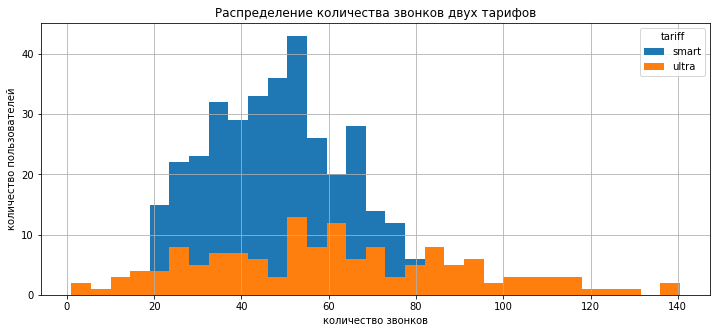

In [107]:
(users_report
    .pivot_table(index='user_id', columns = 'tariff', values='call_count', aggfunc='mean')
    .plot(kind='hist',grid=True, figsize=(12, 5), bins=31)
)
plt.xlabel('количество звонков') 
plt.ylabel('количество пользователей') 
plt.title('Распределение количества звонков двух тарифов')

Распределение немного правосторонние

##### График распределения продолжительности звонков двух тарифов

Text(0.5, 1.0, 'Распределение продолжительности звонков двух тарифов')

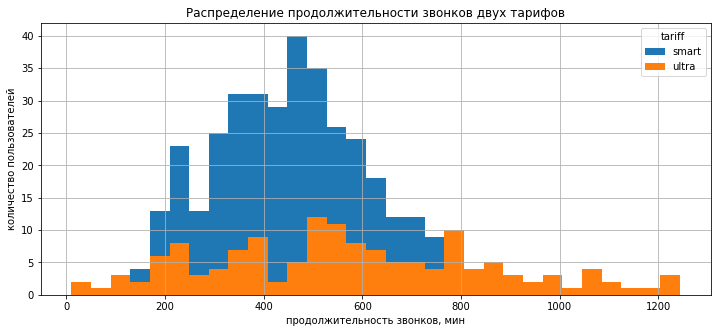

In [108]:
(users_report
 .pivot_table(index='user_id', columns = 'tariff', values='duration', aggfunc='mean')
 .plot(kind='hist',grid=True, figsize=(12, 5), bins=31)
)
plt.xlabel('продолжительность звонков, мин') 
plt.ylabel('количество пользователей') 
plt.title('Распределение продолжительности звонков двух тарифов')

У графиков наблюдается нормальное распределение

##### График распределения выручки двух тарифов

Text(0.5, 1.0, 'Распределение выручки двух тарифов')

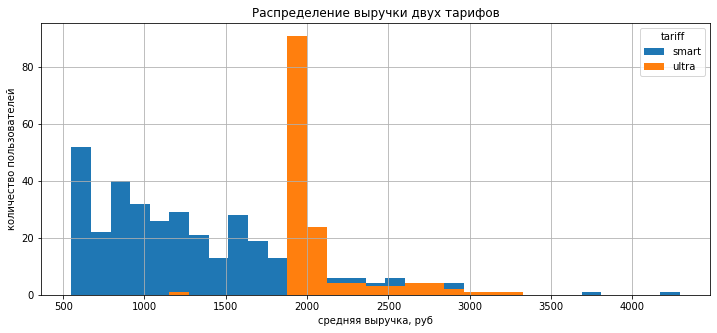

In [109]:
(users_report
  .pivot_table(index='user_id', columns = 'tariff', values='revenue', aggfunc='mean')
   .plot(kind='hist',grid=True, figsize=(12, 5), bins=31)
)
plt.xlabel('средняя выручка, руб') 
plt.ylabel('количество пользователей') 
plt.title('Распределение выручки двух тарифов')

У тарифов smart и ultra - правосторонние распределение

##### График распределения количества сообщений двух тарифов

Text(0.5, 1.0, 'Распределение количества сообщений двух тарифов')

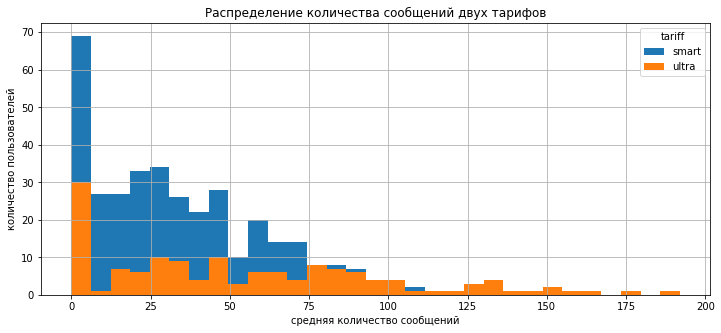

In [110]:
(users_report
 .pivot_table(index='user_id', columns = 'tariff', values='messages', aggfunc='mean')
 .plot(kind='hist',grid=True, figsize=(12, 5), bins=31)
)
plt.xlabel('средняя количество сообщений') 
plt.ylabel('количество пользователей') 
plt.title('Распределение количества сообщений двух тарифов')

Правостороннее распределение

##### График распределения количества мегабайтов двух тарифов

Text(0.5, 1.0, 'Распределение количества мегабайтов двух тарифов')

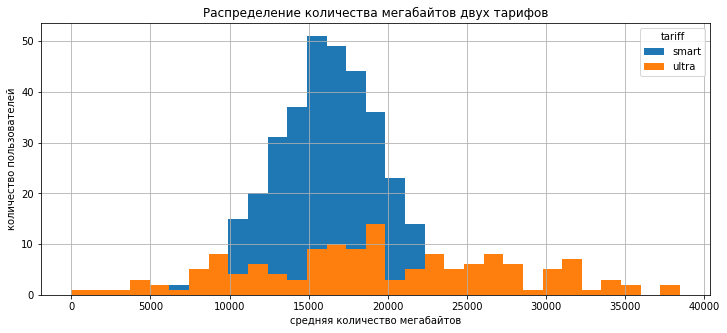

In [111]:
(users_report
 .pivot_table(index='user_id', columns = 'tariff', values='mb_used', aggfunc='mean')
 .plot(kind='hist',grid=True, figsize=(12, 5), bins=31)
)
plt.xlabel('средняя количество мегабайтов') 
plt.ylabel('количество пользователей') 
plt.title('Распределение количества мегабайтов двух тарифов')

Распределение нормальное

#### Гистограммы показали как нормальное (количество мегабайтов, продолжительность звонков), правосторонние (количество звонков, количество сообщений) 

## Проверяем гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Ho: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается

H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Для проверки гипотез используем критический уровень статистической значимости (alpha) - если p-value окажется меньше него - совокупности совпадают
Для проверки гиполезы установим alpha 0.05 (с 95% точности это не случайно)

In [112]:
tarif_smart=users_report[users_report['tariff']=='smart']

In [113]:
tarif_ultra=users_report[users_report['tariff']=='ultra']

In [114]:
tarif_smart['revenue'].mean()

1249.5933423301844

In [115]:
tarif_ultra['revenue'].mean()

2071.0052576235544

In [116]:
alpha = .05
results =st.ttest_ind(
    tarif_smart['revenue'], 
    tarif_ultra['revenue'])
print('p-значение:',results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.562774821320393e-176
Отвергаем нулевую гипотезу


###### p-значение слишком мала, что говорит о том что нулевая гипотеза не верна. Выручка завистит от тарифного плана

#### Проверяем гипотезу:средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Но: средняя выручка пользователей из Москвы равняется выручке пользователей из других регионов

Н1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [117]:
# добавил город пользователя
users_report = users_report.merge(users[['user_id', 'city']], on='user_id', how='left')

In [118]:
moscow=users_report[users_report['city']=='Москва']

In [119]:
city=users_report[users_report['city']!='Москва']

In [120]:
moscow['revenue'].mean()

1526.5786885245902

In [121]:
city['revenue'].mean()

1488.3615444617785

In [122]:
alpha = .05
results =st.ttest_ind(
    moscow['revenue'], 
    city['revenue'])
print('p-значение:',results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.28700848830480036
Не получилось отвергнуть нулевую гипотезу


###### Средняя выручка пользователей Москвы и остальных городов немного различается и с 28% такое совпадение можно получить случайно. Это слишком большая вероятность, чтобы делать вывод о значимом различии между средними выручками.
Нулевая гипотеза верна


# ВЫВОД

Было проведено исследование выборки 500 клиентов компании Мегалайн 2-х тарифов ("ультра" и "смарт")
Суммарная годовая выручка компании от 500 пользователей составила 4.7 млн руб. Причем большую выручку компания получила от клиентов тарифа ультра.
У двух тарифов схожая тенденция к увеличению длительности звонков с января по декабрь. Пользователи тарифа "ультра" больше общаются, также больше отправляют сообщений и больше пользуются интернетом. Средние показатели тарифа ультра также выше. **Выручка завистит от тарифного плана**. Пользователи 2-х тарифов совершенно по разному себя ведут (одни много общаются, так как не боятся переплат ("ультра"), а другие наоборот)

**Если сравнивать среднюю выручку пользователей Москвы и остальных городов , то средние выручки практически совпадают . Значимом различии между средними нет, т.е город не является определяющим фактором в определении выручки**